# Necessary Packages

In [319]:
import pandas as pd
from rapidfuzz import process
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Reading the data

In [320]:
list1 = pd.read_csv("List1.csv")
list2 = pd.read_csv("List2.csv")

In [321]:
list2 = list2.drop_duplicates()

In [322]:
list1_modified = pd.read_csv("List1_modified.csv")

# Functions

In [323]:
def fuzzy_match(query, choices, threshold=100):
    best_match = process.extractOne(query, choices, score_cutoff=threshold)
    if best_match:
        return best_match[0], best_match[1]
    return None, 0

def check_status(row):
    match, score = fuzzy_match(row['Institution Name'], list1_institutions, threshold=95)
    if match:
        return 'present'
    else:
        return 'not present'

In [324]:
def get_address(institution, state):
    address = ""
    flag = False
    if state == "--":
        flag = True
    else:
        flag = False
    try:
        driver.get("https://www.google.com")
        time.sleep(2)
        search = driver.find_element(By.NAME, 'q')
        search.clear()
        if flag:
            search.send_keys(f"{institution}")
        else:
            search.send_keys(f"{institution}, {state}")
        search.send_keys(Keys.ENTER)
        time.sleep(10)
        
        try:
            address = driver.find_element(By.CLASS_NAME, 'LrzXr').text
        except NoSuchElementException:
            driver.get("https://www.google.com/maps")
            time.sleep(2)
            search = driver.find_element(By.NAME, 'q')
            search.clear()
            if flag:
                search.send_keys(f"{institution}, {state}")
            else:
                search.send_keys(f"{institution}, {state}")
            search.send_keys(Keys.ENTER)
            time.sleep(10)
            
            try:
                address = driver.find_element(By.XPATH, """/html/body/div[1]/div[3]/div[8]/div[9]/div/div/div[1]/div[2]/div/div[1]/div/div/div[7]/div[3]/button/div/div[2]/div[1]""").text
            except NoSuchElementException:
                try:
                    driver.find_element(By.XPATH, """/html/body/div[1]/div[3]/div[8]/div[9]/div/div/div[1]/div[2]/div/div[1]/div/div/div[1]/div[1]/div[3]/div/a""").click()
                    time.sleep(3)
                    address = driver.find_element(By.XPATH, """/html/body/div[1]/div[3]/div[8]/div[9]/div/div/div[1]/div[2]/div/div[1]/div/div/div[7]/div[3]/button/div/div[2]/div[1]""").text
                except NoSuchElementException:
                    address = "Not Found"
    
    except Exception as e:
        print(f"Error: {e}")
        address = "Not Found"

    return address

In [325]:
def get_long_lat(institution):
    try:
        driver.get("https://www.google.com/maps")
        time.sleep(2)
        search = driver.find_element(By.NAME, 'q')
        search.clear()
        search.send_keys(f"{institution}")
        search.send_keys(Keys.ENTER)
        time.sleep(10)

        try:
            url = driver.current_url
            if '@' in url:
                coords_part = url.split('@')[1].split(',')[0:2]
                lat = coords_part[0]
                lng = coords_part[1]
                return lat, lng
            else:
                return None, None
        except NoSuchElementException:
            return None, None
    
    except NoSuchElementException:
        return None, None
    
    driver.quit()

In [326]:
def address_split(address):
    address_parts = address.split(", ")
    if len(address_parts) >= 4:
        country = address_parts[-1]
        zip_code = (address_parts[-2].split(" "))[-1]
        city = address_parts[-3]
        street = address_parts[-4]
        return [country, zip_code, city, street]
    else:
        return [None, None, None, None]
    
def zip_extracter(str):
    str = (str.split("-"))[0]
    return str

In [327]:
def street_formatter(str):
    if str == None:
        return None
    else:
        str = (str.split("#"))[0]
        return str
    

In [328]:
# def determine_status(row):
#     zip_code = row['Zip']
#     street_name = row['Street']
    
#     matching_rows = list1_modified[list1_modified['ZIP'] == zip_code]
    
#     if not matching_rows.empty:
#         for _, match_row in matching_rows.iterrows():
#             similarity = fuzz.partial_ratio(street_name, match_row['STREET'])
#             if similarity >= 60:
#                 return 'present'
    
#     return 'not present'

def determine_status(row):
    zip_code = row['Zip']
    street_name = row['Street']
    door_no = row['door_no']
    matching_rows = list1_modified[list1_modified['ZIP'] == zip_code]
    
    if not matching_rows.empty:
        for _, match_row in matching_rows.iterrows():
            street_similarity = fuzz.partial_ratio(street_name, match_row['STREET'])
            door_no_match = door_no == match_row['door_no']
            if street_similarity >= 60 and door_no_match:
                return 'present'

    return 'not present'

In [329]:
def door_no(str):
    if str == None:
        return None
    else:
        str = (str.split(" "))[0]
        return str

In [330]:
def name_formatter(string):
    return string.strip()

# Fuzzy Approach

In [331]:
list1_institutions = list1['INSTNM'].tolist()
list2['status'] = list2.apply(check_status, axis=1)

KeyboardInterrupt: 

In [ ]:
list2.shape

(2039, 3)

In [ ]:
remaining_rows_appr1 = len(list2[list2["status"] == "not present"])
print(remaining_rows_appr1)

36


In [ ]:
mapped_appr1 = list2[list2["status"] == "present"]

approach_1 = []
for i in range(mapped_appr1.shape[0]):
    approach_1.append("Fuzzy 100")

mapped_appr1["Approach"] = approach_1

mapped_appr1.shape

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\3014892236.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_appr1["Approach"] = approach_1


(2003, 4)

In [ ]:
remaining_df_appr = list2[list2["status"] == "not present"]
remaining_df_appr.head(37)

,Institution Name,State,status
26,American Business and Technology University,MO,not present
53,Apex School of Theology,NC,not present
85,Averett University-Non-Traditional Programs,VA,not present
128,Bergin Universiy,CA,not present
171,Broadview College,UT,not present
226,California University of Management and Sciences,CA,not present
254,CEM College-Mayaguez,PR,not present
306,Christian Life College,IL,not present
356,Columbia Central University,PR,not present
357,Columbia Central University-Yauco,PR,not present


# Approach 2

In [ ]:
list = remaining_df_appr
list["Institution Name"] = list["Institution Name"].str.strip()
list.head(37)

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\2668512320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list["Institution Name"] = list["Institution Name"].str.strip()


,Institution Name,State,status
26,American Business and Technology University,MO,not present
53,Apex School of Theology,NC,not present
85,Averett University-Non-Traditional Programs,VA,not present
128,Bergin Universiy,CA,not present
171,Broadview College,UT,not present
226,California University of Management and Sciences,CA,not present
254,CEM College-Mayaguez,PR,not present
306,Christian Life College,IL,not present
356,Columbia Central University,PR,not present
357,Columbia Central University-Yauco,PR,not present


In [ ]:
s = Service(r"D:/Application/chromedriver-win64/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=s)

In [ ]:
addresses = []
for index, row in list.iterrows():
    address = get_address(row['Institution Name'], row['State'])
    addresses.append(address)
    time.sleep(5)

In [ ]:
list['Address'] = addresses

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1311418358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list['Address'] = addresses


In [ ]:
list.head(37)

,Institution Name,State,status,Address
26,American Business and Technology University,MO,not present,"KIRKPATRICK BUILDING, 620 Francis St Suite 218..."
53,Apex School of Theology,NC,not present,"1701 TW Alexander Dr, Durham, NC 27703, United..."
85,Averett University-Non-Traditional Programs,VA,not present,"420 W Main St, Danville, VA 24541, United States"
128,Bergin Universiy,CA,not present,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un..."
171,Broadview College,UT,not present,"1902 W 7800 S, West Jordan, UT 84088, United S..."
226,California University of Management and Sciences,CA,not present,"1126 N Brookhurst St #200, Anaheim, CA 92801, ..."
254,CEM College-Mayaguez,PR,not present,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico"
306,Christian Life College,IL,not present,"404 E Gregory St, Mt Prospect, IL 60056, Unite..."
356,Columbia Central University,PR,not present,"Puerto Rico 183 Km 1.7 Box 8517, Caguas, 00725..."
357,Columbia Central University-Yauco,PR,not present,"3 Calle Betances, Yauco, 00698, Puerto Rico"


In [ ]:
list[['Country', 'Zip', 'City', 'Street']] = list['Address'].apply(lambda x: pd.Series(address_split(x)))
list.head(37)

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\3740610754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list[['Country', 'Zip', 'City', 'Street']] = list['Address'].apply(lambda x: pd.Series(address_split(x)))
C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\3740610754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list[['Country', 'Zip', 'City', 'Street']] = list['Address'].apply(lambda x: pd.Series(address_split(x)))
C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykern

,Institution Name,State,status,Address,Country,Zip,City,Street
26,American Business and Technology University,MO,not present,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218
53,Apex School of Theology,NC,not present,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr
85,Averett University-Non-Traditional Programs,VA,not present,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St
128,Bergin Universiy,CA,not present,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy
171,Broadview College,UT,not present,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S
226,California University of Management and Sciences,CA,not present,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St #200
254,CEM College-Mayaguez,PR,not present,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico",Puerto Rico,00680,Mayagüez,56 Cll Cristy
306,Christian Life College,IL,not present,"404 E Gregory St, Mt Prospect, IL 60056, Unite...",United States,60056,Mt Prospect,404 E Gregory St
356,Columbia Central University,PR,not present,"Puerto Rico 183 Km 1.7 Box 8517, Caguas, 00725...",Puerto Rico,00725,Caguas,Puerto Rico 183 Km 1.7 Box 8517
357,Columbia Central University-Yauco,PR,not present,"3 Calle Betances, Yauco, 00698, Puerto Rico",Puerto Rico,00698,Yauco,3 Calle Betances


In [ ]:
list["Street"] = list["Street"].apply(street_formatter)
list.head(37)

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1418744299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list["Street"] = list["Street"].apply(street_formatter)


,Institution Name,State,status,Address,Country,Zip,City,Street
26,American Business and Technology University,MO,not present,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218
53,Apex School of Theology,NC,not present,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr
85,Averett University-Non-Traditional Programs,VA,not present,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St
128,Bergin Universiy,CA,not present,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy
171,Broadview College,UT,not present,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S
226,California University of Management and Sciences,CA,not present,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St
254,CEM College-Mayaguez,PR,not present,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico",Puerto Rico,00680,Mayagüez,56 Cll Cristy
306,Christian Life College,IL,not present,"404 E Gregory St, Mt Prospect, IL 60056, Unite...",United States,60056,Mt Prospect,404 E Gregory St
356,Columbia Central University,PR,not present,"Puerto Rico 183 Km 1.7 Box 8517, Caguas, 00725...",Puerto Rico,00725,Caguas,Puerto Rico 183 Km 1.7 Box 8517
357,Columbia Central University-Yauco,PR,not present,"3 Calle Betances, Yauco, 00698, Puerto Rico",Puerto Rico,00698,Yauco,3 Calle Betances


In [ ]:
list1_modified["ZIP"] = list1_modified["ZIP"].apply(zip_extracter)

In [ ]:
list1_modified["door_no"] = list1_modified["STREET"].apply(door_no)

In [ ]:
list["door_no"] = list["Street"].apply(door_no)
list.head(37)

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\152786567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list["door_no"] = list["Street"].apply(door_no)


,Institution Name,State,status,Address,Country,Zip,City,Street,Status,door_no
26,American Business and Technology University,MO,not present,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218,not present,620
53,Apex School of Theology,NC,not present,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr,not present,1701
85,Averett University-Non-Traditional Programs,VA,not present,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420
128,Bergin Universiy,CA,not present,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201
171,Broadview College,UT,not present,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S,not present,1902
226,California University of Management and Sciences,CA,not present,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126
254,CEM College-Mayaguez,PR,not present,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico",Puerto Rico,00680,Mayagüez,56 Cll Cristy,not present,56
306,Christian Life College,IL,not present,"404 E Gregory St, Mt Prospect, IL 60056, Unite...",United States,60056,Mt Prospect,404 E Gregory St,not present,404
356,Columbia Central University,PR,not present,"Puerto Rico 183 Km 1.7 Box 8517, Caguas, 00725...",Puerto Rico,00725,Caguas,Puerto Rico 183 Km 1.7 Box 8517,not present,Puerto
357,Columbia Central University-Yauco,PR,not present,"3 Calle Betances, Yauco, 00698, Puerto Rico",Puerto Rico,00698,Yauco,3 Calle Betances,not present,3


In [ ]:
list['Status'] = list.apply(determine_status, axis=1)

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1595325090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list['Status'] = list.apply(determine_status, axis=1)


In [ ]:
list.head(37)

,Institution Name,State,status,Address,Country,Zip,City,Street,Status,door_no
26,American Business and Technology University,MO,not present,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218,not present,620
53,Apex School of Theology,NC,not present,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr,not present,1701
85,Averett University-Non-Traditional Programs,VA,not present,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420
128,Bergin Universiy,CA,not present,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201
171,Broadview College,UT,not present,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S,not present,1902
226,California University of Management and Sciences,CA,not present,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126
254,CEM College-Mayaguez,PR,not present,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico",Puerto Rico,00680,Mayagüez,56 Cll Cristy,not present,56
306,Christian Life College,IL,not present,"404 E Gregory St, Mt Prospect, IL 60056, Unite...",United States,60056,Mt Prospect,404 E Gregory St,not present,404
356,Columbia Central University,PR,not present,"Puerto Rico 183 Km 1.7 Box 8517, Caguas, 00725...",Puerto Rico,00725,Caguas,Puerto Rico 183 Km 1.7 Box 8517,not present,Puerto
357,Columbia Central University-Yauco,PR,not present,"3 Calle Betances, Yauco, 00698, Puerto Rico",Puerto Rico,00698,Yauco,3 Calle Betances,not present,3


In [ ]:
list = list.drop("status", axis=1)

In [ ]:
temp = list[list["Status"] == "present"]
temp.head(temp.shape[0])

,Institution Name,State,Address,Country,Zip,City,Street,Status,door_no
85,Averett University-Non-Traditional Programs,VA,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420
128,Bergin Universiy,CA,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201
226,California University of Management and Sciences,CA,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126
643,Houston Christian University,TX,"7502 Fondren Rd, Houston, TX 77074, United States",United States,77074,Houston,7502 Fondren Rd,present,7502
871,Miller-Motte College,--,"3725 Ramsey St, Fayetteville, NC 28311, United...",United States,28311,Fayetteville,3725 Ramsey St,present,3725
1167,Rochester Christian University,MI,"800 W Avon Rd, Rochester Hills, MI 48307, Unit...",United States,48307,Rochester Hills,800 W Avon Rd,present,800
1563,University of Maine at Machias,ME,"116 Obrien Ave, Machias, ME 04654, United States",United States,04654,Machias,116 Obrien Ave,present,116


In [ ]:
temp2 = list[list["Status"] == "not present"]
temp2.shape

(29, 9)

In [ ]:
temp3 = pd.concat([temp, temp2], axis = 0)

In [ ]:
temp3.head(37)

,Institution Name,State,Address,Country,Zip,City,Street,Status,door_no
85,Averett University-Non-Traditional Programs,VA,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420
128,Bergin Universiy,CA,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201
226,California University of Management and Sciences,CA,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126
643,Houston Christian University,TX,"7502 Fondren Rd, Houston, TX 77074, United States",United States,77074,Houston,7502 Fondren Rd,present,7502
871,Miller-Motte College,--,"3725 Ramsey St, Fayetteville, NC 28311, United...",United States,28311,Fayetteville,3725 Ramsey St,present,3725
1167,Rochester Christian University,MI,"800 W Avon Rd, Rochester Hills, MI 48307, Unit...",United States,48307,Rochester Hills,800 W Avon Rd,present,800
1563,University of Maine at Machias,ME,"116 Obrien Ave, Machias, ME 04654, United States",United States,04654,Machias,116 Obrien Ave,present,116
26,American Business and Technology University,MO,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218,not present,620
53,Apex School of Theology,NC,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr,not present,1701
171,Broadview College,UT,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S,not present,1902


In [ ]:
temp3.to_csv("sept1.csv", index=False)

In [ ]:
approach = []
for i in range(temp3.shape[0]):
    approach.append("Street and building_no")

In [ ]:
temp3["Approach"] = approach

In [ ]:
temp3.head()

,Institution Name,State,Address,Country,Zip,City,Street,Status,door_no,Approach
85,Averett University-Non-Traditional Programs,VA,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420,Street and building_no
128,Bergin Universiy,CA,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201,Street and building_no
226,California University of Management and Sciences,CA,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126,Street and building_no
643,Houston Christian University,TX,"7502 Fondren Rd, Houston, TX 77074, United States",United States,77074,Houston,7502 Fondren Rd,present,7502,Street and building_no
871,Miller-Motte College,--,"3725 Ramsey St, Fayetteville, NC 28311, United...",United States,28311,Fayetteville,3725 Ramsey St,present,3725,Street and building_no


# Approach 3

In [ ]:
mapped_appr2 = temp3[temp3["Status"] == "present"]

In [ ]:
mapped_appr2 = pd.concat([mapped_appr1, mapped_appr2])
mapped_appr2.shape

(2010, 11)

In [ ]:
mapped_appr2.tail(10)

,Institution Name,State,status,Approach,Address,Country,Zip,City,Street,Status,door_no
2037,University of Kentucky,KY,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2038,Lafayette College,PA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2039,Worcester Polytechnic Institute,MA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,Averett University-Non-Traditional Programs,VA,NaN,Street and building_no,"420 W Main St, Danville, VA 24541, United States",United States,24541,Danville,420 W Main St,present,420
128,Bergin Universiy,CA,NaN,Street and building_no,"10201 Old Redwood Hwy, Penngrove, CA 94951, Un...",United States,94951,Penngrove,10201 Old Redwood Hwy,present,10201
226,California University of Management and Sciences,CA,NaN,Street and building_no,"1126 N Brookhurst St #200, Anaheim, CA 92801, ...",United States,92801,Anaheim,1126 N Brookhurst St,present,1126
643,Houston Christian University,TX,NaN,Street and building_no,"7502 Fondren Rd, Houston, TX 77074, United States",United States,77074,Houston,7502 Fondren Rd,present,7502
871,Miller-Motte College,--,NaN,Street and building_no,"3725 Ramsey St, Fayetteville, NC 28311, United...",United States,28311,Fayetteville,3725 Ramsey St,present,3725
1167,Rochester Christian University,MI,NaN,Street and building_no,"800 W Avon Rd, Rochester Hills, MI 48307, Unit...",United States,48307,Rochester Hills,800 W Avon Rd,present,800
1563,University of Maine at Machias,ME,NaN,Street and building_no,"116 Obrien Ave, Machias, ME 04654, United States",United States,04654,Machias,116 Obrien Ave,present,116


In [ ]:
list = temp3[temp3["Status"] == "not present"]
list.shape

(29, 10)

In [ ]:
def long_lat_formatter(value):
    truncated_value = float(str(value)[:str(value).find('.') + 3] ) # Truncates without rounding
    return truncated_value

In [ ]:
def long_lat_formatter_rounded(value):
    truncated_value = round(value, 2) # Truncates without rounding
    return truncated_value

In [ ]:
list1_modified["longi"] = list1_modified["LON"].apply(long_lat_formatter)
list1_modified["latti"] = list1_modified["LAT"].apply(long_lat_formatter)

In [ ]:
list1_modified.head(10)

,Institution Name_x,State,LAT,LON,latti,longi
0,alabama a & m university,AL,34.783368,-86.568502,34.78,-86.56
1,university of alabama at birmingham,AL,33.505697,-86.799345,33.50,-86.79
2,amridge university,AL,32.362609,-86.174010,32.36,-86.17
3,university of alabama in huntsville,AL,34.724557,-86.640449,34.72,-86.64
4,alabama state university,AL,32.364317,-86.295677,32.36,-86.29
5,the university of alabama,AL,33.211875,-87.545978,33.21,-87.54
6,central alabama community college,AL,32.924780,-85.945266,32.92,-85.94
7,athens state university,AL,34.806793,-86.964698,34.80,-86.96
8,auburn university at montgomery,AL,32.367360,-86.177544,32.36,-86.17
9,auburn university,AL,32.599378,-85.488258,32.59,-85.48


In [ ]:
list1_modified[["longi", "latti"]].nunique()

longi    2845
latti    1801
dtype: int64

In [ ]:
list1_modified.columns

Index(['Institution Name_x', 'State', 'LAT', 'LON', 'latti', 'longi'], dtype='object')

In [ ]:
list1_modified = list1_modified[["Institution Name_x", "State", "LAT", "LON", "latti", "longi"]]

In [ ]:
list1_modified.head()

,Institution Name_x,State,LAT,LON,latti,longi
0,alabama a & m university,AL,34.783368,-86.568502,34.78,-86.57
1,university of alabama at birmingham,AL,33.505697,-86.799345,33.51,-86.80
2,amridge university,AL,32.362609,-86.174010,32.36,-86.17
3,university of alabama in huntsville,AL,34.724557,-86.640449,34.72,-86.64
4,alabama state university,AL,32.364317,-86.295677,32.36,-86.30


In [ ]:
list.shape

(29, 10)

In [ ]:
s = Service(r"D:/Application/chromedriver-win64/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=s)

list['Latitude'] = None
list['Longitude'] = None

for index, row in list.iterrows():
    address = f"{row['Institution Name']}, {row['State']}"
    latitude, longitude = get_long_lat(address)
    list.at[index, 'Latitude'] = latitude
    list.at[index, 'Longitude'] = longitude

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1897412258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list['Latitude'] = None
C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1897412258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list['Longitude'] = None


In [ ]:
list.head()

,Institution Name,State,Address,Country,Zip,City,Street,Status,door_no,Approach,Latitude,Longitude
26,American Business and Technology University,MO,"KIRKPATRICK BUILDING, 620 Francis St Suite 218...",United States,64501,St Joseph,620 Francis St Suite 218,not present,620,Street and building_no,39.7671801,-94.8547972
53,Apex School of Theology,NC,"1701 TW Alexander Dr, Durham, NC 27703, United...",United States,27703,Durham,1701 TW Alexander Dr,not present,1701,Street and building_no,35.9225168,-78.8438807
171,Broadview College,UT,"1902 W 7800 S, West Jordan, UT 84088, United S...",United States,84088,West Jordan,1902 W 7800 S,not present,1902,Street and building_no,40.6109664,-111.9446466
254,CEM College-Mayaguez,PR,"56 Cll Cristy, Mayagüez, 00680, Puerto Rico",Puerto Rico,00680,Mayagüez,56 Cll Cristy,not present,56,Street and building_no,18.1991449,-67.1486993
306,Christian Life College,IL,"404 E Gregory St, Mt Prospect, IL 60056, Unite...",United States,60056,Mt Prospect,404 E Gregory St,not present,404,Street and building_no,42.0745234,-87.93391


In [ ]:
arr = list["Latitude"].to_list()
type(arr[0])

str

In [ ]:
list = list[["Institution Name", "State", "Latitude", "Longitude"]]
list["latti"] = pd.to_numeric(list["Latitude"]).apply(long_lat_formatter)
list["longi"] = pd.to_numeric(list["Longitude"]).apply(long_lat_formatter)
list.head(30)

,Institution Name,State,Latitude,Longitude,latti,longi
26,American Business and Technology University,MO,39.7671801,-94.8547972,39.76,-94.85
53,Apex School of Theology,NC,35.9225168,-78.8438807,35.92,-78.84
171,Broadview College,UT,40.6109664,-111.9446466,40.61,-111.94
254,CEM College-Mayaguez,PR,18.1991449,-67.1486993,18.19,-67.14
306,Christian Life College,IL,42.0745234,-87.93391,42.07,-87.93
356,Columbia Central University,PR,18.2233342,-66.0251364,18.22,-66.02
357,Columbia Central University-Yauco,PR,18.0344252,-66.8516246,18.03,-66.85
422,DeVry University-Missouri,MO,38.7910079,-97.7849583,38.79,-97.78
426,DeVry University-Pennsylvania,PA,40.0866712,-82.8592612,40.08,-82.85
427,DeVry University-Tennessee,TN,36.0837057,-86.7000617,36.08,-86.70


In [ ]:
# list = list.rename(columns={
#     "Latitude":"latti",
#     "Longitude": "longi"
# })
list.head()

,Institution Name,State,Latitude,Longitude,latti,longi
26,American Business and Technology University,MO,39.7671801,-94.8547972,39.76,-94.85
53,Apex School of Theology,NC,35.9225168,-78.8438807,35.92,-78.84
171,Broadview College,UT,40.6109664,-111.9446466,40.61,-111.94
254,CEM College-Mayaguez,PR,18.1991449,-67.1486993,18.19,-67.14
306,Christian Life College,IL,42.0745234,-87.93391,42.07,-87.93


In [ ]:
list["latti"].nunique()
list["longi"].nunique()

29

In [ ]:
(pd.merge(list1_modified, list, on=["longi", "latti"])).head(10)

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
1,columbia central university-caguas,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
5,presidio graduate school,CA,37.786891,-122.400814,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
6,alliant international university-san francisco,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366
7,strayer university-alexandria campus,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473


In [ ]:
duplicate_df = pd.merge(list1_modified, list, on=["longi", "latti"])


In [ ]:
duplicate_df.head(10)

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
1,columbia central university-caguas,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
5,presidio graduate school,CA,37.786891,-122.400814,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
6,alliant international university-san francisco,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366
7,strayer university-alexandria campus,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473


In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

# Download required NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\Naga Hari
[nltk_data]     Priyan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Naga Hari
[nltk_data]     Priyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def rem_hyphen(string):
    string = (string.split("-"))[0]
    return string

In [ ]:
duplicate_df["Institution Name_x"] = duplicate_df["Institution Name_x"].apply(rem_hyphen)
duplicate_df.head(10)

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
5,presidio graduate school,CA,37.786891,-122.400814,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231
6,alliant international university,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366
7,strayer university,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473


In [ ]:
list.shape

(29, 6)

In [ ]:
def clean_and_tokenize(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return set(tokens)

def strict_word_phrasing_status(row):
    tokens_x = clean_and_tokenize(row['Institution Name_x'])
    tokens_y = clean_and_tokenize(row['Institution Name'])
    common_tokens = tokens_x.intersection(tokens_y)
    if tokens_x.issubset(tokens_y) or tokens_y.issubset(tokens_x):
        return 'present'
    else:
        return 'not present'

duplicate_df['status'] = duplicate_df.apply(strict_word_phrasing_status, axis=1)

matched_df = duplicate_df[duplicate_df['status'] == 'present']

matched_df.head()


,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present


In [ ]:
duplicate_df.head(10)

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present
5,presidio graduate school,CA,37.786891,-122.400814,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present
6,alliant international university,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366,not present
7,strayer university,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473,not present


In [ ]:
mapped_appr2.head()

,Institution Name,State,status,Approach,Address,Country,Zip,City,Street,Status,door_no
0,Aaniiih Nakoda College,MT,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abilene Christian University,TX,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abraham Lincoln University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Academy College,MN,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Academy of Art University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
duplicate_df.head(duplicate_df.shape[0])

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status,Approach
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present,long_lat_format and NLP
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present,long_lat_format and NLP
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present,long_lat_format and NLP
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP
5,presidio graduate school,CA,37.786891,-122.400814,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP
6,alliant international university,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366,not present,long_lat_format and NLP
7,strayer university,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473,not present,long_lat_format and NLP


In [ ]:
approach_3 = []
for i in range(duplicate_df.shape[0]):
    approach_3.append("long_lat_format and NLP")
duplicate_df["Approach"] = approach_3
duplicate_df.head()

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status,Approach
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present,long_lat_format and NLP
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present,long_lat_format and NLP
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present,long_lat_format and NLP
4,minerva university,CA,37.783609,-122.409425,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP


In [ ]:
duplicate_df.shape

(8, 12)

In [ ]:
listx = pd.concat([duplicate_df, list])
listx.shape

(37, 13)

In [ ]:
listy = listx.drop_duplicates(subset=["Institution Name"])
listy.shape

(29, 13)

In [ ]:
listy.head()

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status,Approach,State
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP,NaN
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present,long_lat_format and NLP,NaN
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present,long_lat_format and NLP,NaN
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present,long_lat_format and NLP,NaN
6,alliant international university,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366,not present,long_lat_format and NLP,NaN


In [ ]:
listy.shape

(29, 13)

In [ ]:
listy.head(30)

,Institution Name_x,State_x,LAT,LON,latti,longi,Institution Name,State_y,Latitude,Longitude,status,Approach,State
0,academy of art university,CA,37.787943,-122.400578,37.78,-122.40,FIDM-Fashion Institute of Design & Merchandisi...,CA,37.7864794,-122.4094231,not present,long_lat_format and NLP,NaN
1,columbia central university,PR,18.223290,-66.022543,18.22,-66.02,Columbia Central University,PR,18.2233342,-66.0251364,present,long_lat_format and NLP,NaN
2,university of the virgin islands,VI,18.344193,-64.972866,18.34,-64.97,"University of the Virgin Islands, St. Thomas",VI,18.3432395,-64.9754493,present,long_lat_format and NLP,NaN
3,university of arkansas grantham,AR,34.775996,-92.343582,34.77,-92.34,Grantham University,--,34.7760922,-92.3462736,present,long_lat_format and NLP,NaN
6,alliant international university,CA,37.847164,-122.293200,37.84,-122.29,SAE Expression College,CA,37.8476272,-122.2980366,not present,long_lat_format and NLP,NaN
7,strayer university,VA,38.801540,-77.080321,38.80,-77.08,Washington University of Science and Technology,--,38.8017483,-77.0855473,not present,long_lat_format and NLP,NaN
26,NaN,NaN,NaN,NaN,39.76,-94.85,American Business and Technology University,NaN,39.7671801,-94.8547972,NaN,NaN,MO
53,NaN,NaN,NaN,NaN,35.92,-78.84,Apex School of Theology,NaN,35.9225168,-78.8438807,NaN,NaN,NC
171,NaN,NaN,NaN,NaN,40.61,-111.94,Broadview College,NaN,40.6109664,-111.9446466,NaN,NaN,UT
254,NaN,NaN,NaN,NaN,18.19,-67.14,CEM College-Mayaguez,NaN,18.1991449,-67.1486993,NaN,NaN,PR


In [ ]:
list_present = listy[listy["status"] == "present"]
list_present.shape

(3, 13)

In [ ]:
mapped_appr2.head()

,Institution Name,State,status,Approach,Address,Country,Zip,City,Street,Status,door_no
0,Aaniiih Nakoda College,MT,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abilene Christian University,TX,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abraham Lincoln University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Academy College,MN,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Academy of Art University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mapped_appr3 = pd.concat([mapped_appr2, list_present])
mapped_appr3.shape

(2013, 20)

In [ ]:
mapped_appr3.head()

,Institution Name,State,status,Approach,Address,Country,Zip,City,Street,Status,door_no,Institution Name_x,State_x,LAT,LON,latti,longi,State_y,Latitude,Longitude
0,Aaniiih Nakoda College,MT,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abilene Christian University,TX,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Abraham Lincoln University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Academy College,MN,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Academy of Art University,CA,present,Fuzzy 100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mapped_appr3 = mapped_appr3[["Institution Name", "Status", "Approach", "Institution Name_x"]]
mapped_appr3.head()

,Institution Name,Status,Approach,Institution Name_x
0,Aaniiih Nakoda College,NaN,Fuzzy 100,NaN
1,Abilene Christian University,NaN,Fuzzy 100,NaN
2,Abraham Lincoln University,NaN,Fuzzy 100,NaN
3,Academy College,NaN,Fuzzy 100,NaN
4,Academy of Art University,NaN,Fuzzy 100,NaN


In [ ]:
mapped_appr3.shape

(2013, 4)

# Approach 4

In [ ]:
list2["Institution Name"] = list2["Institution Name"].apply(name_formatter)

In [ ]:
names_in_df = set(mapped_appr3["Institution Name"].unique())
names_in_list2 = set(list2["Institution Name"].unique())

# Find the names in list2 that are not in df
missing_names = names_in_list2 - names_in_df

# Filter list2 to get only the rows with these missing names
missing_data_df = list2[list2["Institution Name"].isin(missing_names)]

In [ ]:
missing_data_df.head(30)

,Institution Name,State,status
26,American Business and Technology University,MO,not present
53,Apex School of Theology,NC,not present
171,Broadview College,UT,not present
254,CEM College-Mayaguez,PR,not present
306,Christian Life College,IL,not present
357,Columbia Central University-Yauco,PR,not present
422,DeVry University-Missouri,MO,not present
426,DeVry University-Pennsylvania,PA,not present
427,DeVry University-Tennessee,TN,not present
463,Eastern International College-Belleville,NJ,not present


In [ ]:
list = missing_data_df[missing_data_df["status"] == "not present"]

In [ ]:
list["Institution Name"] = list["Institution Name"].str.lower()

C:\Users\Naga Hari Priyan\AppData\Local\Temp\ipykernel_14316\1058190031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list["Institution Name"] = list["Institution Name"].str.lower()


In [ ]:
inst_x = list["Institution Name"].to_list()
inst_y = list1_modified["Institution Name_x"].to_list()

In [ ]:
print(inst_y)

['alabama a & m university', 'university of alabama at birmingham', 'amridge university', 'university of alabama in huntsville', 'alabama state university', 'the university of alabama', 'central alabama community college', 'athens state university', 'auburn university at montgomery', 'auburn university', 'birmingham-southern college', 'chattahoochee valley community college', 'south university-montgomery', 'enterprise state community college', 'coastal alabama community college', 'faulkner university', 'gadsden state community college', 'new beginning college of cosmetology', 'george c wallace community college-dothan', 'george c wallace state community college-hanceville', 'george c wallace state community college-selma', 'herzing university-birmingham', 'huntingdon college', 'heritage christian university', 'j. f. drake state community and technical college', 'j f ingram state technical college', 'jacksonville state university', 'jefferson state community college', 'john c calhoun st

In [ ]:
type(inst_x[0])

str

In [ ]:
mapped = []
status = []

str = "morris brown college"

for inst in inst_x:
    if inst in inst_y:
        mapped.append(inst)
        status.append("present")
    else:
        mapped.append(inst)
        status.append("not present")

In [ ]:
temp_df = pd.DataFrame(
    {
        "Institution Name":mapped,
        "Status":status
    }
)

mapped_appr4 = temp_df[temp_df["Status"] == "present"]
mapped_appr4.head()

not_mapped = temp_df[temp_df["Status"] == "not present"]
not_mapped.shape

(25, 2)

In [ ]:
mapped = pd.concat([mapped_appr3, mapped_appr4])
mapped.shape

(2014, 4)

In [ ]:
mapped = mapped.drop(columns="Status")

In [ ]:
Status_final = []
for i in range(mapped.shape[0]):
    Status_final.append("present")

In [ ]:
mapped["Status"] = Status_final

In [ ]:
mapped.tail(25)

,Institution Name,Approach,Institution Name_x,Status
2026,University of Wisconsin-Oshkosh,Fuzzy 100,NaN,present
2027,University of Wisconsin-Parkside,Fuzzy 100,NaN,present
2028,University of Wisconsin-River Falls,Fuzzy 100,NaN,present
2029,University of Wisconsin-Stevens Point,Fuzzy 100,NaN,present
2030,University of Wisconsin-Stout,Fuzzy 100,NaN,present
2031,University of Wisconsin-Superior,Fuzzy 100,NaN,present
2032,University of Wisconsin-Whitewater,Fuzzy 100,NaN,present
2033,Villanova University,Fuzzy 100,NaN,present
2034,Colgate University,Fuzzy 100,NaN,present
2035,Vanderbilt University,Fuzzy 100,NaN,present


In [ ]:
unmapped = not_mapped

In [ ]:
final_df = pd.concat([mapped, unmapped])
final_df.shape

(2039, 4)

# Accuracy

In [ ]:
validation_df = pd.read_excel("Validation_Set.xlsx")
comparison_df = final_df

In [ ]:
filtered_comparison_df = comparison_df[comparison_df['Institution Name'].isin(validation_df['Institution Name'])]
merged_df = pd.merge(validation_df, filtered_comparison_df, on='Institution Name', suffixes=('_validation', '_comparison'))

In [ ]:
merged_df.head()

,Institution Name,Web url,latitude,Longitude,Status_validation,State,Unnamed: 6,Unnamed: 7,Approach,Institution Name_x,Status_comparison
0,Berry College,NaN,NaN,NaN,present,GA,NaN,NaN,Fuzzy 100,NaN,present
1,Curry College,NaN,NaN,NaN,present,MA,NaN,NaN,Fuzzy 100,NaN,present
2,City College-Gainesville,NaN,NaN,NaN,present,FL,NaN,NaN,Fuzzy 100,NaN,present
3,Academy College,NaN,NaN,NaN,present,MN,NaN,NaN,Fuzzy 100,NaN,present
4,Case Western Reserve University,NaN,NaN,NaN,present,OH,NaN,NaN,Fuzzy 100,NaN,present


In [ ]:
correctly_matched = (merged_df['Status_validation'] == merged_df['Status_comparison']).sum()
total_comparisons = len(merged_df)
accuracy = correctly_matched / total_comparisons if total_comparisons > 0 else 0

In [ ]:
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 98.19%


Figure(640x480)


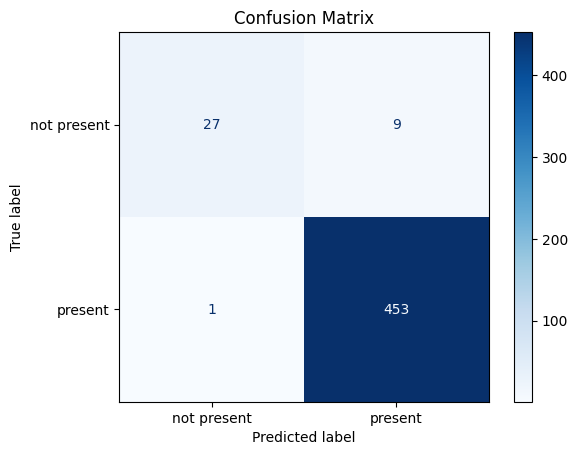

In [ ]:
validation_dict = validation_df.set_index('Institution Name')['Status'].to_dict()
comparison_dict = comparison_df.set_index('Institution Name')['Status'].to_dict()

        # Initialize lists to store true and predicted values
y_true = []
y_pred = []

        # Loop through the validation dataset
for institution, true_status in validation_dict.items():
    if institution in comparison_dict:
        pred_status = comparison_dict[institution]
        y_true.append(true_status)
        y_pred.append(pred_status)
    else:
        # If institution is not in the comparison dataset, consider it a misclassification
        y_true.append(true_status)
        y_pred.append('not present')  # or some default value for missing cases

        # Convert statuses to numeric values
status_mapping = {'present': 1, 'not present': 0}
y_true_numeric = [status_mapping[status] for status in y_true]
y_pred_numeric = [status_mapping[status] for status in y_pred]

        # Compute confusion matrix
conf_matrix = confusion_matrix(y_true_numeric, y_pred_numeric)

        # Display the confusion matrix
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['not present', 'present'])
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix')

        # Display the plot in Streamlit
print(fig)


In [ ]:
final_df.to_csv("processed_df.csv", index= False)